In [20]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [35]:
!pip install bqplot

     |████████████████████████████████| 4.7 MB 418 kB/s eta 0:00:01


In [3]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython import display as IPyDisplay
import ipyvolume as ipv
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
import time
from tensorflow_graphics.util import safe_ops, asserts, shape
import math
from scipy.spatial.transform import Rotation as R

# QUICK TEST: STARTS FROM RED, GO TO BLUE
import bqplot.scales


In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12763414522425612777
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6332508352395367736
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15795073236107142045
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2673016832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13482617340591822035
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Code for Conversions

- Euler Angles (Z-Y-Z axes rotations) -> Quaternion

- Quaternion -> Euler Angles

- d_q = distance between 2 quaternions

In [5]:
def euler2quaternion(angles):
    """Convert Euler angles to quaternion
    
    Parameters
    ----------
    angles: np.ndarray
        Array of shape (N, 3), where 3 are the 3 anles of rotation around Z-Y-Z axes respectivelly.
        
    Returns
    -------
    quaternion: np.ndarray
        Array of shape (N, 4), where 4 is the 1 real part of quaternion and 3 imaginary parts of quaternion.
    """
    angles = tf.convert_to_tensor(value=angles)

    shape.check_static(tensor=angles, tensor_name="angles", has_dim_equals=(-1, 3))
    
    theta_z1, theta_y, theta_z0 = tf.unstack(angles, axis=-1)

    # create rotation matrix
    c1 = tf.cos(theta_z1)
    c2 = tf.cos(theta_y)
    c3 = tf.cos(theta_z0)

    s1 = tf.sin(theta_z1)
    s2 = tf.sin(theta_y)
    s3 = tf.sin(theta_z0)

    # PROJECTIONS CODE
    r00 = c1*c2*c3-s1*s3
    r01 = -(c1*s3+c2*c3*s1) ##
    r02 = -(-c3*s2)  ##
    r10 = -(-c3*s1-c1*c2*s3) ##
    r11 = c1*c3-c2*s1*s3
    r12 = s2*s3
    r20 = -(c1*s2) ##
    r21 = s1*s2 
    r22 = c2

    w2 = 1/4*(1+ r00 + r11 + r22)
    w2_is_pos = tf.greater(w2, 0)
    
    x2 = -1/2*(r11+r22)
    x2_is_pos = tf.greater(x2, 0)
    
    y2 = 1/2*(1-r22)
    y2_is_pos = tf.greater(y2, 0)
    
    w = tf.compat.v1.where(w2_is_pos, tf.sqrt(w2), tf.zeros_like(w2))
    x = tf.compat.v1.where(w2_is_pos, 1/(4*w)*(r21-r12),
                                        tf.compat.v1.where(x2_is_pos, tf.sqrt(x2), tf.zeros_like(x2)))
    y = tf.compat.v1.where(w2_is_pos, 1/(4*w)*(r02-r20),
                                        tf.compat.v1.where(x2_is_pos, r01/(2*x), 
                                                                    tf.compat.v1.where(y2_is_pos, tf.sqrt(y2), tf.zeros_like(y2))))
    
    z = tf.compat.v1.where(w2_is_pos, 1/(4*w)*(r10-r01), 
                                        tf.compat.v1.where(x2_is_pos, r02/(2*x), 
                                                                    tf.compat.v1.where(y2_is_pos, r12/(2*y), tf.ones_like(y2))))
    
    return tf.stack((x, y, z, w), axis=-1)

def quaternion2euler(quaternions):
    """ Convert quaternion to Euler angles
    
    Parameters
    ----------
    quaternions: np.ndarray
        The array of shape (N, 4), where 4 is the 1 real part of quaternion and 3 imaginary parts of quaternion.
    
    Returns
    -------
    angles: np.ndarray
        The array of shape (N, 3), where 3 are the 3 anles of rotation around Z-Y-Z axes respectivelly.
    """
    def general_case(r02, r12, r20, r21, r22, eps_addition):
        """Handles the general case."""
        theta_y = tf.acos(r22)
        #sign_sin_theta_y = safe_ops.nonzero_sign(tf.sin(theta_y))
        
        r02 = safe_ops.nonzero_sign(r02) * eps_addition + r02
        r22 = safe_ops.nonzero_sign(r22) * eps_addition + r22
        
        theta_z0 = tf.atan2(r12, r02)
        theta_z1 = tf.atan2(r21, -r20)
        return tf.stack((theta_z1, theta_y, theta_z0), axis=-1)

    def gimbal_lock(r22, r11, r10, eps_addition):
        """Handles Gimbal locks.
        It is gimbal when r22 is -1 or 1"""
        sign_r22 = safe_ops.nonzero_sign(r22)
        r11 = safe_ops.nonzero_sign(r11) * eps_addition + r11
        
        theta_z0 = tf.atan2(sign_r22 * r10, r11)
        
        theta_y = tf.constant(math.pi/2.0, dtype=r20.dtype) - sign_r22 * tf.constant(math.pi/2.0, dtype=r20.dtype)
        theta_z1 = tf.zeros_like(theta_z0)
        angles = tf.stack((theta_z1, theta_y, theta_z0), axis=-1)
        return angles

    with tf.compat.v1.name_scope(None, "euler_from_quaternion", [quaternions]):
        quaternions = tf.convert_to_tensor(value=quaternions)

        shape.check_static(
            tensor=quaternions,
            tensor_name="quaternions",
            has_dim_equals=(-1, 4))

        x, y, z, w = tf.unstack(quaternions, axis=-1)
        tx = safe_ops.safe_shrink(2.0 * x, -2.0, 2.0, True)
        ty = safe_ops.safe_shrink(2.0 * y, -2.0, 2.0, True)
        tz = safe_ops.safe_shrink(2.0 * z, -2.0, 2.0, True)
        twx = tx * w
        twy = ty * w
        twz = tz * w
        txx = tx * x
        txy = ty * x
        txz = tz * x
        tyy = ty * y
        tyz = tz * y
        tzz = tz * z

        # The following is clipped due to numerical instabilities that can take some
        # enties outside the [-1;1] range.
        
        r00 = safe_ops.safe_shrink(1.0 - (tyy + tzz), -1.0, 1.0, True)
        r01 = safe_ops.safe_shrink(txy - twz, -1.0, 1.0, True)
        r02 = safe_ops.safe_shrink(txz + twy, -1.0, 1.0, True)

        r10 = safe_ops.safe_shrink(txy + twz, -1.0, 1.0, True)
        r11 = safe_ops.safe_shrink(1.0 - (txx + tzz), -1.0, 1.0, True)
        r12 = safe_ops.safe_shrink(tyz - twx, -1.0, 1.0, True)

        r20 = safe_ops.safe_shrink(txz - twy, -1.0, 1.0, True)
        r21 = safe_ops.safe_shrink(tyz + twx, -1.0, 1.0, True)
        r22 = safe_ops.safe_shrink(1.0 - (txx + tyy), -1.0, 1.0, True)
        
        eps_addition = asserts.select_eps_for_addition(quaternions.dtype)
        general_solution = general_case(r02, r12, r20, r21, r22, eps_addition)
        gimbal_solution = gimbal_lock(r22, r11, r10, eps_addition)
        
        # The general solution is unstable close to the Gimbal lock, and the gimbal
        # solution is not toooff in these cases.
        # Check if r22 is 1 or -1
        is_gimbal = tf.less(tf.abs(tf.abs(r22) - 1.0), 1.0e-6)
        gimbal_mask = tf.stack((is_gimbal, is_gimbal, is_gimbal), axis=-1)
        
        return tf.compat.v1.where(gimbal_mask, gimbal_solution, general_solution)              
    
def d_q(q1, q2):
    """Distance between 2 quaternions
    
    The quaternion distance takes values between [0, pi]
    
    Parameters
    ----------
    q1: tf.tensor/np.ndarray
        1st quaternion
    q2: tf.tensor/np.ndarray
        2nd quaternion
    
    Returns
    -------
    : distnace between these 2 quaternions
    
    """
    q1 = tf.cast(tf.convert_to_tensor(value=q1), dtype=tf.float64)
    q2 = tf.cast(tf.convert_to_tensor(value=q2), dtype=tf.float64)
    
    shape.check_static(tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
    shape.check_static(tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

    q1 = quaternion.normalize(q1)
    q2 = quaternion.normalize(q2)
    
    dot_product = vector.dot(q1, q2, keepdims=False)
    
    # Ensure dot product is in range [-1. 1].
    eps_dot_prod = 1.8 * asserts.select_eps_for_addition(dot_product.dtype)
    dot_product = safe_ops.safe_shrink(dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

    return 2.0 * tf.acos(tf.abs(dot_product)) 

def distance_difference(angles_predicted, angles_true):
    """Average quaternion distance between true and predicted quaterniosn"""
    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)
    qd = np.mean(d_q(q_predicted, q_true).numpy())
    print(f"Mean `quaternion` distance between true and predicted values: {qd:.3f} rad ({np.degrees(qd):.3f} degrees)")

    return qd

In [6]:
# def euler2quaternion(angles, transposed=True):
#     return R.from_euler('ZYZ', angles).as_quat()


# def quaternion2euler(quaternions, transposed=True):
#     return R.from_quat(quaternions).as_euler("ZYZ")         
    
# def d_q(q1, q2):
#     """Distance between 2 quaternions
    
#     The quaternion distance takes values between [0, pi]
    
#     Parameters
#     ----------
#     q1: tf.tensor/np.ndarray
#         1st quaternion
#     q2: tf.tensor/np.ndarray
#         2nd quaternion
    
#     Returns
#     -------
#     : distnace between these 2 quaternions
    
#     """
#     q1 = tf.cast(tf.convert_to_tensor(value=q1), dtype=tf.float64)
#     q2 = tf.cast(tf.convert_to_tensor(value=q2), dtype=tf.float64)
    
#     shape.check_static(tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
#     shape.check_static(tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

#     q1 = quaternion.normalize(q1)
#     q2 = quaternion.normalize(q2)
    
#     dot_product = vector.dot(q1, q2, keepdims=False)
    
#     # Ensure dot product is in range [-1. 1].
#     eps_dot_prod = 1.8 * asserts.select_eps_for_addition(dot_product.dtype)
#     dot_product = safe_ops.safe_shrink(dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

#     return 2.0 * tf.acos(tf.abs(dot_product)) 

# def distance_difference(angles_predicted, angles_true):
#     """Average quaternion distance between true and predicted quaterniosn"""
#     q_predicted = euler2quaternion(angles_predicted)
#     q_true = euler2quaternion(angles_true)
#     qd = np.mean(d_q(q_predicted, q_true).numpy())
#     print(f"Mean `quaternion` distance between true and predicted values: {qd:.3f} rad ({np.degrees(qd):.3f} degrees)")

#     return qd

# Code for Optimization 

\begin{equation}
\label{eq:phase1}
\operatorname*{min}_{R  \in SO(4), m \in \{-1,1\}} \frac{1}{n} \sum_{i=1} d_q(q_i, R \begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} \hat{q_i})
\end{equation}

- $d_q$ is the distance between two quaternions

\begin{equation}
\label{eq:eq2}
d(q_1,q_2)=2arccos(|<q_1,q_2>|)
\end{equation}

- $q_i \in S^3$ is the quaternion of a true rotation angles

- $\hat{q_i} \in S^3$ is the rotation of the estimatied rotation angles

- $R \in SO(4)$ is $4x4$ orthogonal matrix with determinant 1 that represents a global rotation

- $m \in \{-1,1\}$ represents a global reflection ($m=1$ no reflection, $m=-1$ reflection)

- $\begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} = \begin{bmatrix}
m & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$

# Read data for the optimization

#### Prediction angles from previous phase that we want to align with true angles

In [7]:
def angles_transpose(angles):
    cols = [2, 1, 0]
    idx = np.empty_like(cols)
    idx[cols] = np.arange(len(cols))
    angles[:] = -angles[:, idx]
    return angles

In [8]:
quaternion_predicted = np.load("../data/predicted_quaternions2.npy")

In [9]:
angles_predicted = quaternion2euler(quaternion_predicted).numpy()

---

#### True angles

In [10]:
angles_true = np.load("../data/angles_true.npy")

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [96]:

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
import time
from IPython import display as IPyDisplay
from scipy.spatial.transform import Rotation as R


def euler6tomarix4d(a_R1, a_R2):

    xy, xz, xw = tf.unstack(a_R1, axis=-1)
    yz, yw, zw = tf.unstack(a_R2, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_quaternion(m, a_R1, a_R2, q_predicted):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R1, a_R2)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return q_predicted_rotated

def loss_alignment(m, a_R1, a_R2, q_predicted, q_true):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R1, a_R2)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R1, a_R2, q_predicted, q_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R1, a_R2, q_predicted, q_true)
        gradient = tape.gradient(loss_value, a_R1)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, learning_rate, angles_true, angles_predicted):
    
    collect_data = []

    optimizer = Adam(learning_rate=learning_rate)

    time_start = time.time()

    report = ""

    losses = np.empty(steps)
    Rs = np.empty((steps, 6))
    angles_predicted = tf.convert_to_tensor(angles_predicted)

    #euler = [3.55673309, 4.19968558, 2.59819985, 1.30204558, 3.47833943, 4.3547665] #tf.random.uniform([6], 0, 2*np.pi, dtype=tf.float64) #np.zeros(6, dtype=np.float64)
    euler_1st = [3. , 2., 3.]
    euler_2nd = [tf.convert_to_tensor([3.06273475, 2.56179193, 3.82298411])]
    a_R1 = [tf.Variable(euler_1st)]
    a_R2 = euler_2nd
    

    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(range(len(angles_predicted)), size=batch_size))

        # Compute distances between projections
        qt = [q_true[i]      for i in idx]
        qp = [q_predicted[i] for i in idx]

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient_alignment(m, a_R1, a_R2, qp, qt)
        optimizer.apply_gradients(zip(gradients, a_R1))
        Rs[step-1] = np.array(list(a_R1[0].numpy()) + list(a_R2[0].numpy()))

        update_lr = 300
        if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
            learning_rate *= 0.1

        # Visualize progress periodically
        if step % 10 == 0:
            qu = update_quaternion(m, a_R1, a_R2, q_predicted)

            collect_data.append(qu.numpy())

            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            fig, axs = plt.subplots(1, 3, figsize=(24,7))

            # Distance count subplot (batches)
            qpr = update_quaternion(m, a_R1, a_R2, qp)
            d1 = d_q(qpr, qt)
            axs[0].set_xlim(0, np.pi)
            #axs[0].set_ylim(0, batch_size)
            axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
            s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            # Optimization loss subplot
            axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel('loss');
            axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

            # Distance count subplot (full)
            q_predicted_rot = update_quaternion(m, a_R1, a_R2, q_predicted)
            d2 = d_q(q_predicted_rot, q_true)
            axs[2].set_xlim(0, np.pi)
            # axs[2].set_ylim(0, len(angles_true))
            axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
            s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(.1)


        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

        if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
            break;

    print(report)
    print("---")
    return m, a_R1, a_R2, losses, np.array(collect_data), Rs

# Successful convergence

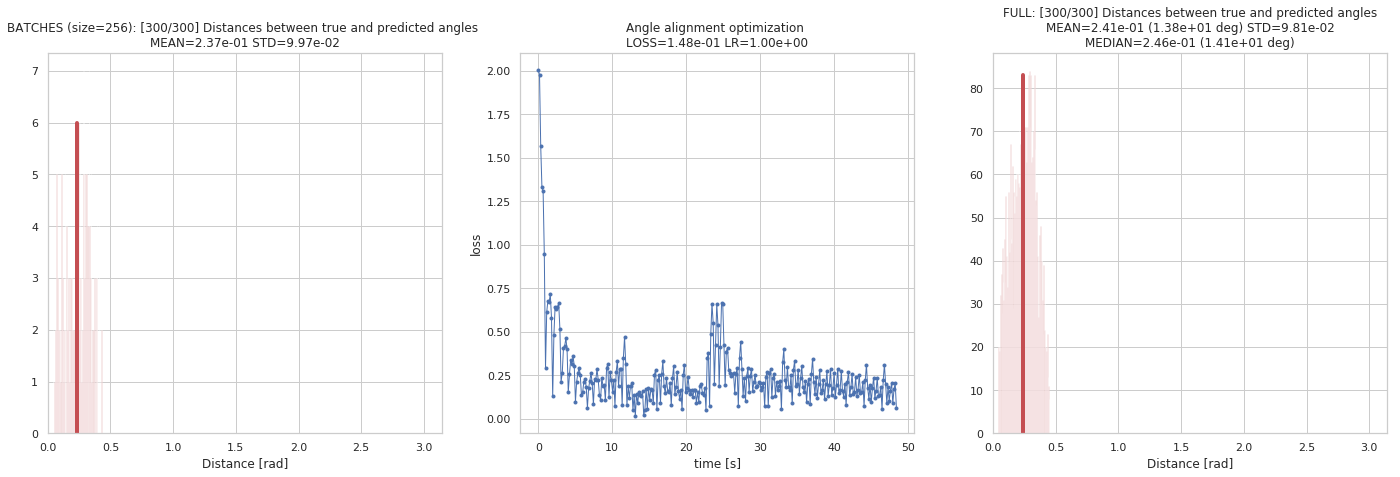

step 30/300 (5s): loss = 6.77e-01
step 60/300 (9s): loss = 2.04e-01
step 90/300 (14s): loss = 1.85e-01
step 120/300 (19s): loss = 1.82e-01
step 150/300 (24s): loss = 2.25e-01
step 180/300 (29s): loss = 3.02e-01
step 210/300 (34s): loss = 2.09e-01
step 240/300 (39s): loss = 2.06e-01
step 270/300 (44s): loss = 1.93e-01
step 300/300 (49s): loss = 1.71e-01

---


In [156]:
m, rotation1, rotation2, loss, collect_data, Rs  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=300, 
                                                 batch_size=256, 
                                                 learning_rate=1, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted)

In [98]:
np.savez('lr0.01.npz', Rs=Rs, loss=loss)

In [118]:
np.savez('lr0.1.npz', Rs=Rs, loss=loss)

In [157]:
np.savez('lr1.0.npz', Rs=Rs, loss=loss)

In [99]:
# rotation1, rotation2

In [100]:
# rotation = [tf.Variable([5.10555144, 0.5510573 , 0.35186033, 3.22172636, 3.72154994, 6.96309418])]

Collect solution space

In [14]:
q_true = euler2quaternion(angles_true)
x_size, y_size, z_size = 50, 50, 50
x, y, z = np.meshgrid(np.linspace(0, 2*np.pi, x_size), np.linspace(0, 2*np.pi, y_size), np.linspace(0., 2*np.pi, z_size))

losses = []rotation1, rotation2
rotations = []

x = x.flatten()
y = y.flatten()
z = z.flatten()


for i, j, k in zip(x, y, z):
    # iterate first 3 dimensions, last 3 are fixed to the estimated ones
    a_R1 = [tf.Variable([i, j, k])]
   
    losses.append(loss_alignment([1., 1., 1., 1.], a_R1, rotation2, quaternion_predicted, q_true))
    rotations.append(a_R1[0].numpy())
    
losses = np.array(losses)
rotations = np.array(rotations)

In [16]:
np.save("losses3d.npy", losses)
np.save("rotations3d.npy", rotations)

---

In [158]:
roi = np.arange(50*50*50)
losses = np.take(np.load("losses3d.npy"), roi, axis=0)
rotations = np.take(np.load("rotations3d.npy"), roi, axis=0)
lr1 = np.load("lr0.01.npz")
lr1_Rs, lr1_loss = lr1['Rs'], lr1['loss']
# Rs_lr2 = np.load("opt_rotations_lr0.1.npy")
# Rs_lr3 = np.load("opt_rotations_lr0.001.npy")
losses = (losses-min(losses))/(max(losses)-min(losses))

In [159]:
losses.shape, rotations.shape, Rs_lr1.shape

((125000,), (125000, 3), (300, 6))

In [160]:
x, y, z = rotations[:,0], rotations[:,1], rotations[:,2]

In [162]:
ipv.figure()
colss = np.empty((len(losses), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(losses):
    colss[i, :] = list(cmap(c))
s = ipv.scatter(x, y, z, color=colss, size=0.8, alpha=0.2)
s.material.transparent = True

loss_opt = (loss - min(loss))/(max(loss) - min(loss))
cols = np.empty((len(loss_opt), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(loss_opt):
    cols[i, :] = list(cmap(c))
ipv.scatter(Rs[:,0], Rs[:,1], Rs[:,2], color=cols)
ipv.show()   

In [111]:
ipv.screenshot()

Output()

In [208]:
losses = np.load("losses3d.npy")

x_size, y_size, z_size = 50, 50, 20
x, y, z = np.meshgrid(np.linspace(0, 2*np.pi, x_size), np.linspace(0, 2*np.pi, y_size), np.linspace(0., 1., z_size))
x = x.flatten()
y = y.flatten()
z = z.flatten()

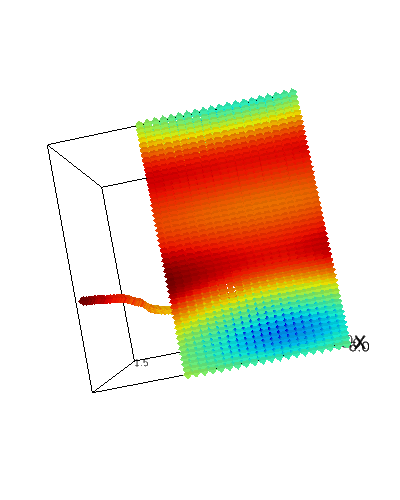

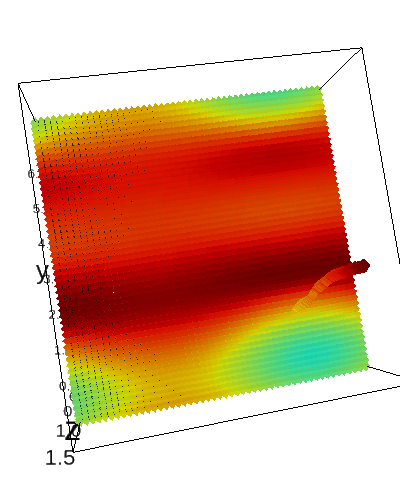

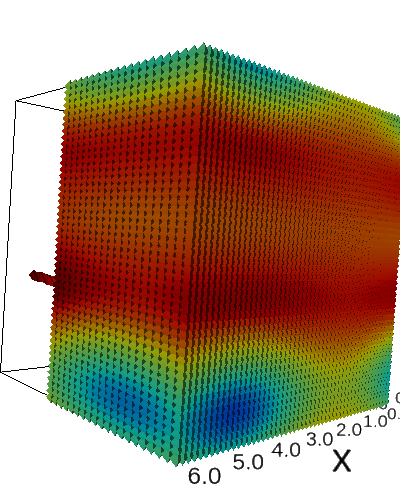

In [210]:
losses = (losses-min(losses))/(max(losses)-min(losses))

# QUICK TEST: STARTS FROM RED, GO TO BLUE
import bqplot.scales

ipv.figure()
colss = np.empty((len(losses), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(losses):
    colss[i, :] = list(cmap(c))
s = ipv.scatter(x, y, z, color=colss, size=2, alpha=0.2)
s.material.transparent = True

loss_opt = (loss - min(loss))/(max(loss) - min(loss))
cols = np.empty((len(loss_opt), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(loss_opt):
    cols[i, :] = list(cmap(c))
ipv.scatter(Rs[:,0], Rs[:,1], Rs[:,2], color=cols)
ipv.show()   

In [213]:
ipv.screenshot()

Output()

# 2D plots

In [163]:
roi = np.arange(50*50*50)
losses = np.take(np.load("losses3d.npy"), roi, axis=0)
rotations = np.take(np.load("rotations3d.npy"), roi, axis=0)

# LR=0.01
lr1 = np.load("lr0.01.npz")
lr1_Rs, lr1_loss = lr1['Rs'], lr1['loss']

# LR=0.1
lr2 = np.load("lr0.1.npz")
lr2_Rs, lr2_loss = lr2['Rs'], lr2['loss']

# LR=0.001
lr3 = np.load("lr1.0.npz")
lr3_Rs, lr3_loss = lr3['Rs'], lr3['loss']

losses = (losses-min(losses))/(max(losses)-min(losses))

In [164]:
losses.shape, rotations.shape, Rs_lr1.shape

((125000,), (125000, 3), (300, 6))

In [165]:
x, y, z = rotations[:,0], rotations[:,1], rotations[:,2]

In [166]:
q_true = euler2quaternion(angles_true)

x_size, y_size, z_size = 50, 50, 50

i = 20
x = x.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
y = y.reshape((x_size, y_size, z_size ))[:, :, i].flatten()

losses_part = losses.reshape((x_size, y_size, z_size ))[:, :, i].flatten()

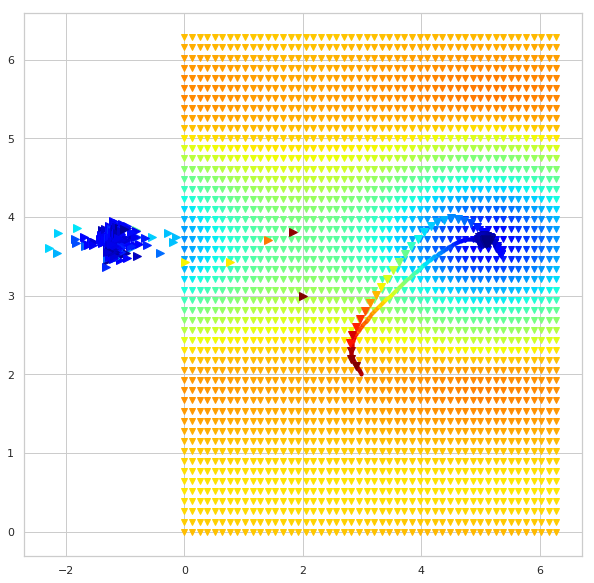

In [172]:
cmap = plt.get_cmap('jet')

color_grid = np.empty((len(losses_part), 4))
for i, c in enumerate(losses_part):
    color_grid[i, :] = list(cmap(c))
    
fig = plt.figure(figsize=(10, 10))
for i in range(len(losses_part)):
    plt.plot(x[i], y[i], markersize=6, marker='v', color=color_grid[i], lw=0)
    
############
loss_opt = (lr1_loss - min(lr1_loss))/(max(lr1_loss) - min(lr1_loss))
color_lr1 = np.empty((len(loss_opt), 4))
for i, c in enumerate(loss_opt):
    color_lr1[i, :] = list(cmap(c))
for i in range(len(loss_opt)):
    plt.plot(lr1_Rs[:,0][i], lr1_Rs[:,1][i], markersize=3, marker='o', color=color_lr1[i])
    
############
loss_opt = (lr2_loss - min(lr2_loss))/(max(lr2_loss) - min(lr2_loss))
color_lr2 = np.empty((len(loss_opt), 4))
for i, c in enumerate(loss_opt):
    color_lr2[i, :] = list(cmap(c))
for i in range(len(loss_opt)):
    plt.plot(lr2_Rs[:,0][i], lr2_Rs[:,1][i], markersize=8, marker='v', color=color_lr2[i])
    
############
loss_opt = (lr3_loss - min(lr3_loss))/(max(lr3_loss) - min(lr3_loss))
color_lr3 = np.empty((len(loss_opt), 4))
for i, c in enumerate(loss_opt):
    color_lr3[i, :] = list(cmap(c))
for i in range(len(loss_opt)):
    plt.plot(lr3_Rs[:,0][i], lr3_Rs[:,1][i], markersize=8, marker='>', color=color_lr3[i])

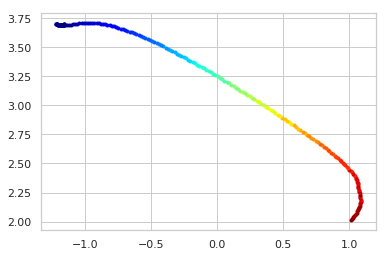

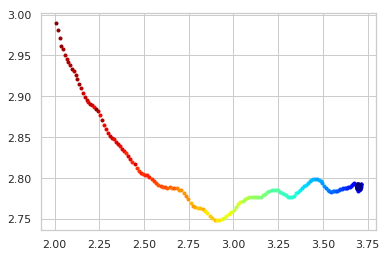

In [49]:
loss_opt = (loss - min(loss))/(max(loss) - min(loss))#/ np.linalg.norm(loss)
cols = np.empty((len(loss_opt), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(loss_opt):
    cols[i, :] = list(cmap(c))
    
for i in range(len(loss_opt)):
    plt.plot(Rs[:,0][i], Rs[:,1][i], markersize=3, marker='o', color=cols[i])
plt.show()

for i in range(len(loss_opt)):
    plt.plot(Rs[:,1][i], Rs[:,2][i], markersize=3, marker='o', color=cols[i])
plt.show()

# Unsuccessful convergence

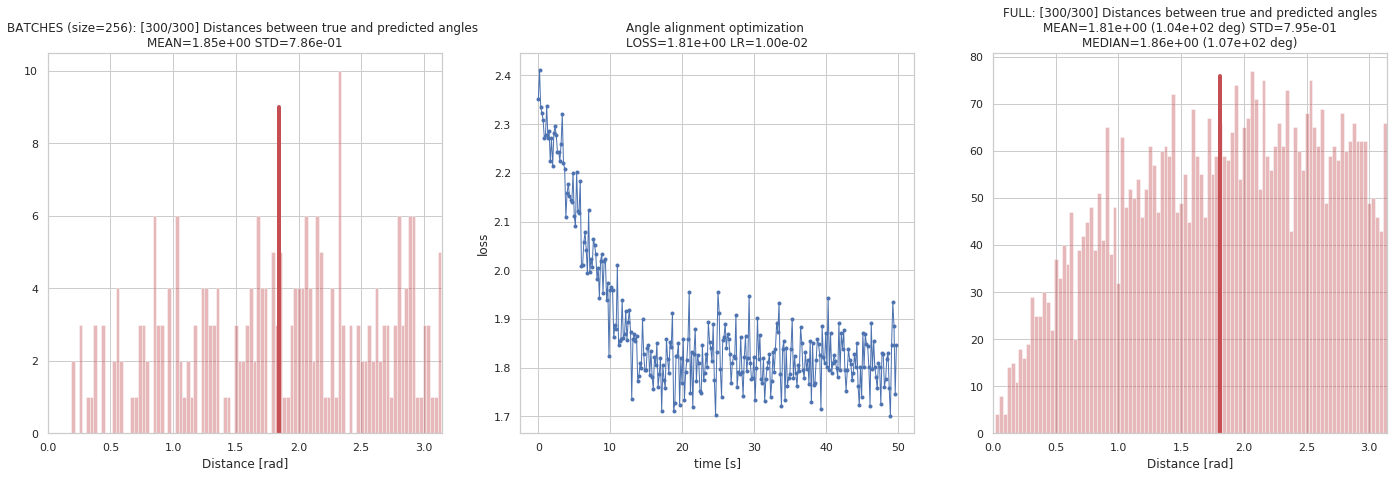

step 30/300 (5s): loss = 2.25e+00
step 60/300 (9s): loss = 2.04e+00
step 90/300 (15s): loss = 1.87e+00
step 120/300 (20s): loss = 1.80e+00
step 150/300 (25s): loss = 1.81e+00
step 180/300 (30s): loss = 1.83e+00
step 210/300 (35s): loss = 1.81e+00
step 240/300 (40s): loss = 1.81e+00
step 270/300 (45s): loss = 1.82e+00
step 300/300 (51s): loss = 1.81e+00

---


In [220]:
m, rotation, loss, collect_data, Rs  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=300, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted)

In [221]:
rotation

[<tf.Variable 'Variable:0' shape=(6,) dtype=float64, numpy=
 array([4.02911244, 2.54279087, 3.381663  , 3.56250892, 0.46362053,
        6.02107848])>]

In [233]:
q_true = euler2quaternion(angles_true)
x_size, y_size, z_size = 50, 50, 50
x, y, z = np.meshgrid(np.linspace(0, 2*np.pi, x_size), np.linspace(0, 2*np.pi, y_size), np.linspace(0., 2*np.pi, z_size))

losses = []

x = x.flatten()
y = y.flatten()
z = z.flatten()

for i, j, k in zip(x, y, z):
    a_R = [tf.Variable([i, j, k] + list(rotation[0].numpy()[3:]))]
    losses.append(loss_alignment([1., 1., 1., 1.], a_R, quaternion_predicted, q_true))
losses = np.array(losses)

In [234]:
np.save("losses3d_not.npy", losses)

In [341]:
losses = np.load("losses3d_not.npy")
losses = (losses-min(losses))/(max(losses)-min(losses))
x_size, y_size, z_size = 50, 50, 50
x, y, z = np.meshgrid(np.linspace(0, 2*np.pi, x_size), np.linspace(0, 2*np.pi, y_size), np.linspace(0., 2*np.pi, z_size))
x = x.flatten()
y = y.flatten()
z = z.flatten()

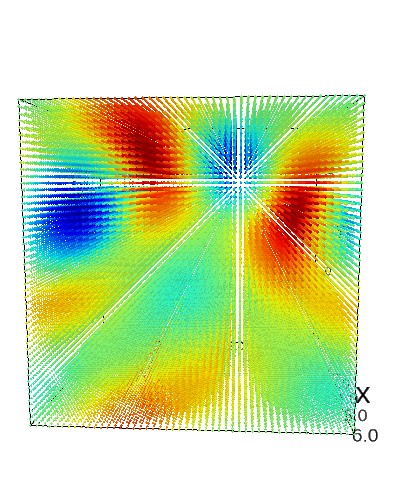

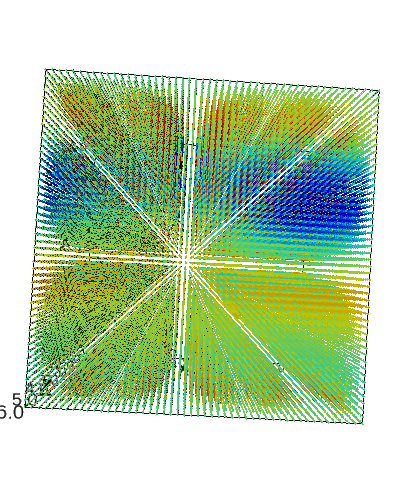

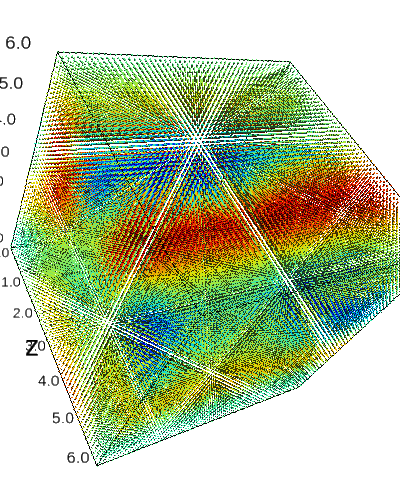

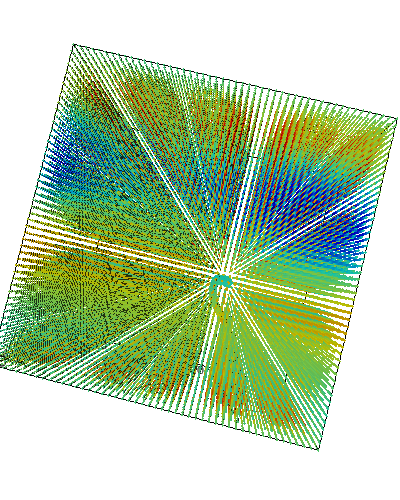

In [342]:
# QUICK TEST: STARTS FROM RED, GO TO BLUE
import bqplot.scales

ipv.figure()
colss = np.empty((len(losses), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(losses):
    colss[i, :] = list(cmap(c))
s = ipv.scatter(x, y, z, color=colss, size=0.5, alpha=0.2)
s.material.transparent = True

losses = np.load("losses3d_not.npy")
loss_opt = (loss - min(losses))/(max(losses) - min(losses))
cols = np.empty((len(loss_opt), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(loss_opt):
    cols[i, :] = list(cmap(c))
ipv.scatter(Rs[:,0], Rs[:,1], Rs[:,2], color=cols)
ipv.show()   

In [347]:
ipv.screenshot()

Output()

In [308]:
losses = np.load("losses3d_not.npy")
losses = (losses-min(losses))/(max(losses)-min(losses))
x_size, y_size, z_size = 50, 50, 50
x, y, z = np.meshgrid(np.linspace(0, 2*np.pi, x_size), np.linspace(0, 2*np.pi, y_size), np.linspace(0., 2*np.pi, z_size))
x = x.flatten()
y = y.flatten()
z = z.flatten()

In [309]:
#q_true = euler2quaternion(angles_true)
#size = 50
#x, y = np.meshgrid(np.linspace(0, 2*np.pi, size), np.linspace(0, 2*np.pi, size))
i = 26
x = x.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
y = y.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
losses_part = losses.reshape((x_size, y_size, z_size ))[:, :, i].flatten()

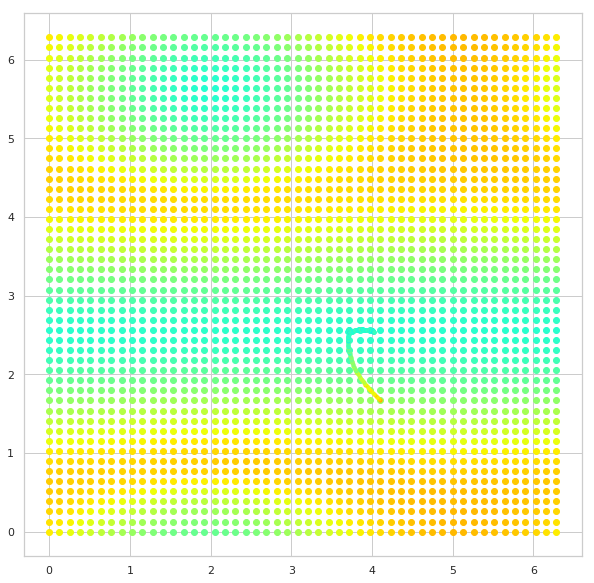

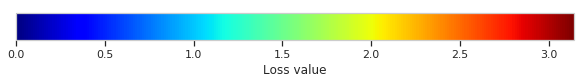

In [339]:
colss = np.empty((len(losses_part), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(losses_part):
    colss[i, :] = list(cmap(c))
    
fig = plt.figure(figsize=(10, 10))
for i in range(len(losses_part)):
    plt.plot(x[i], y[i], markersize=6, marker='o', color=colss[i], lw=0)
    
losses = np.load("losses3d_not.npy")
loss_opt = (loss - min(losses))/(max(losses) - min(losses))
cols = np.empty((len(loss_opt), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(loss_opt):
    cols[i, :] = list(cmap(c))
    
for i in range(len(loss_opt)):
    plt.plot(Rs[:,0][i], Rs[:,1][i], markersize=3, marker='o', color=cols[i])

    
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

#cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0., vmax=np.pi)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Loss value')
fig.show()

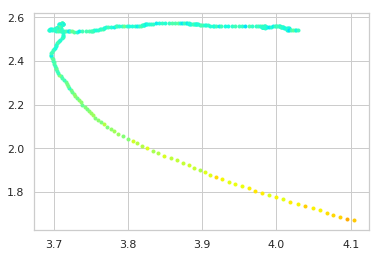

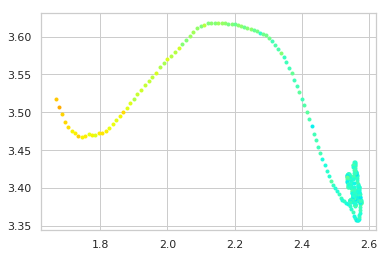

In [343]:
#loss_opt = (loss - min(losses_part))/(max(losses_part) - min(losses_part))#/ np.linalg.norm(loss)
cols = np.empty((len(loss_opt), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(loss_opt):
    cols[i, :] = list(cmap(c))
    
for i in range(len(loss_opt)):
    plt.plot(Rs[:,0][i], Rs[:,1][i], markersize=3, marker='o', color=cols[i])
plt.show()

for i in range(len(loss_opt)):
    plt.plot(Rs[:,1][i], Rs[:,2][i], markersize=3, marker='o', color=cols[i])
plt.show()

# Polar Plot

In [ ]:
angles_predicted_all = np.zeros((*collect_data.shape[0:2], 3))
for i, q in enumerate(collect_data):
    angles_predicted_all[i, :] = R.from_quat(q).as_euler("zyz") % (2*np.pi)

In [ ]:
# PREDICTED ANGLES ITERATION    
xyz = np.zeros(angles_predicted_all.shape)
for i, a in enumerate(angles_predicted_all):
    z0, y1, z1 = a[:,0], a[:,1], a[:,2]
    x = z1*np.sin(y1)*np.cos(z0)
    y = z1*np.sin(y1)*np.sin(z0)
    z = z1*np.cos(y1)
    xyz[i,:,:] = np.array([x, y, z]).T
    
# TRUE ANGLES
xyz_true = np.zeros(angles_true.shape)
z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

xyz_true = np.array([x, y, z]).T

# PREDICTED ANGLES
xyz_predicted = np.zeros(angles_predicted.shape)
z0, y1, z1 = angles_predicted[:,0], angles_predicted[:,1], angles_predicted[:,2]

x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

xyz_predicted = np.array([x, y, z]).T

In [ ]:
ipv.figure()
s = ipv.scatter(xyz[:, :,0], xyz[:, :,1], xyz[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(xyz_true[:,0], xyz_true[:,1], xyz_true[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
ipv.animation_control(s, interval=100)
ipv.show()

# Rotation Vector Plot

In [29]:
arr2 = R.from_euler('zyz', angles_true).as_rotvec()
arr3 = np.zeros((len(angles_predicted_all), *arr2.shape))
for i, a in enumerate(angles_predicted_all):
    arr3[i,:] = R.from_euler('zyz', a).as_rotvec()

ipv.figure()
s = ipv.scatter(arr3[:, :,0], arr3[:, :,1], arr3[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=100)
ipv.show()

# Angle Alignment for Transpose (just test)

In [100]:
angles_predicted_T = angles_transpose(angles_predicted)
angles_predicted_T

array([[ 2.97444801, -1.69700539,  0.27767634],
       [-1.6639683 , -1.04998219, -0.59764091],
       [-1.20397157, -1.4117166 , -0.2497224 ],
       ...,
       [ 0.46647467, -1.29031964, -1.25690316],
       [ 1.60739494, -0.42865127, -0.1440733 ],
       [-0.09104401, -1.32784058,  0.72799575]])

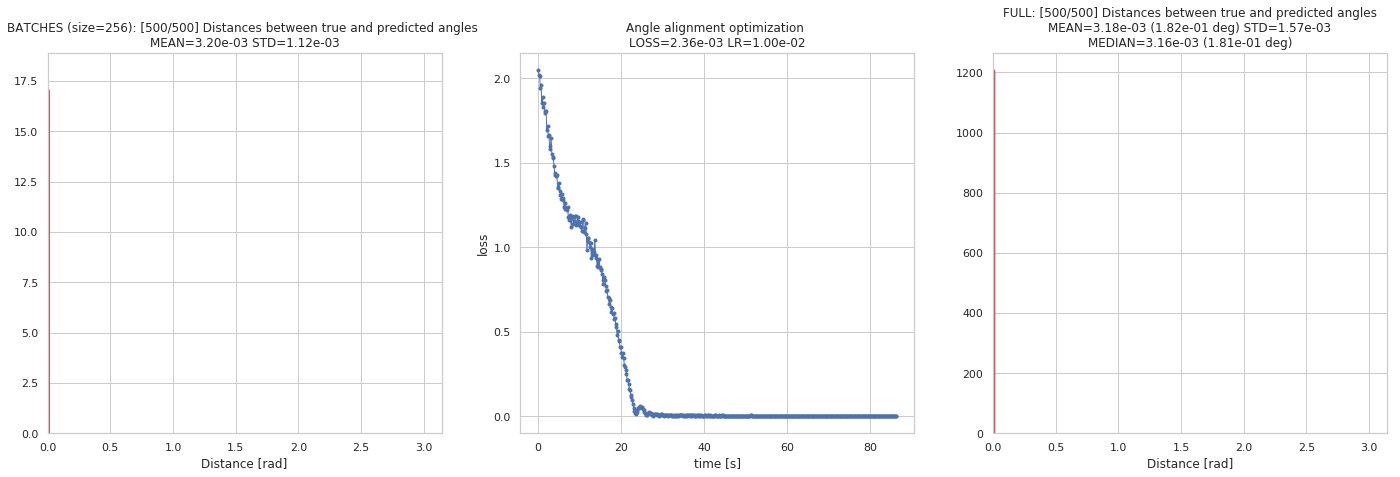

step 50/500 (10s): loss = 1.50e+00
step 100/500 (19s): loss = 9.87e-01
step 150/500 (27s): loss = 2.71e-01
step 200/500 (35s): loss = 8.43e-03
step 250/500 (44s): loss = 3.96e-03
step 300/500 (54s): loss = 3.11e-03
step 350/500 (62s): loss = 2.82e-03
step 400/500 (71s): loss = 2.65e-03
step 450/500 (79s): loss = 2.55e-03
step 500/500 (87s): loss = 2.49e-03

---


In [106]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[-1., 1., 1., 1.],
                                                 steps=500, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted_T)

In [107]:
m, rotation[0].numpy(), loss[-1]

([-1.0, 1.0, 1.0, 1.0],
 array([ 5.10430533,  0.55311296,  3.4936543 ,  3.22003963,  2.56188079,
        -0.68129539]),
 0.001778713521433596)

# Polar Plot

In [109]:
angles_predicted_all = np.zeros((*collect_data.shape[0:2], 3))
for i, q in enumerate(collect_data):
    angles_predicted_all[i, :] = R.from_quat(q).as_euler("zyz")

In [110]:
# PREDICTED ANGLES ITERATION    
xyz = np.zeros(angles_predicted_all.shape)
for i, a in enumerate(angles_predicted_all):
    z0, y1, z1 = a[:,0], a[:,1], a[:,2]
    x = z1*np.sin(y1)*np.cos(z0)
    y = z1*np.sin(y1)*np.sin(z0)
    z = z1*np.cos(y1)
    xyz[i,:,:] = np.array([x, y, z]).T
    
# TRUE ANGLES
xyz_true = np.zeros(angles_true.shape)
z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

xyz_true = np.array([x, y, z]).T

# PREDICTED ANGLES
xyz_predicted = np.zeros(angles_predicted.shape)
z0, y1, z1 = angles_predicted[:,0], angles_predicted[:,1], angles_predicted[:,2]

x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

xyz_predicted = np.array([x, y, z]).T

In [112]:
ipv.figure()
s = ipv.scatter(xyz[:, :,0], xyz[:, :,1], xyz[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(xyz_true[:,0], xyz_true[:,1], xyz_true[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
ipv.animation_control(s, interval=50)
ipv.show()

# Rotation Vector Plot

In [113]:
arr2 = R.from_euler('zyz', angles_true).as_rotvec()
arr3 = np.zeros((len(angles_predicted_all), *arr2.shape))
for i, a in enumerate(angles_predicted_all):
    arr3[i,:] = R.from_euler('zyz', a).as_rotvec()

ipv.figure()
s = ipv.scatter(arr3[:, :,0], arr3[:, :,1], arr3[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=1)
ipv.show()

#### Plot the Topology

Consider the solid ball in $\mathbb {R} ^{3}$ of radius π (that is, all points of $\mathbb {R} ^{3}$ of distance π or less from the origin). Given the above, for every point in this ball there is a rotation, with axis through the point and the origin, and rotation angle equal to the distance of the point from the origin. The identity rotation corresponds to the point at the center of the ball. Rotation through angles between 0 and −π correspond to the point on the same axis and distance from the origin but on the opposite side of the origin. The one remaining issue is that the two rotations through π and through −π are the same. So we identify (or "glue together") antipodal points on the surface of the ball. After this identification, we arrive at a topological space homeomorphic to the rotation group. Reference [wiki](https://en.wikipedia.org/wiki/3D_rotation_group)

---

In [8]:
losses = np.load("losses3d.npy")
#rotations = np.load("rotations3d.npy")

In [9]:
losses.shape

(50000,)